# Naive neural network

In [29]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import MSELoss_method, cross_entropy_loss_method, predict, accuracy_func_method
from Code.descent_methods import SGD_adam, SGD
from Code.data_handling import load_MNIST_8, load_MNIST_28, append_run_to_file, load_run_from_file
from Code.softmax_regression import softmax_beta_init, softmax_model, softmax
from Code.neural_network import _beta_init, get_neural_network_model
from Code.plot import plot_faulty_predictions, plot_confusion_matrix, plot_grid_search_result, plot_some_imgs, plot_test_results

from jax import jit, nn, grad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the default font size for text elements (e.g., titles, labels)
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

# Set filename start. Create the folder if gone
filepath_location = "Figures/b/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])

### Training the neural network

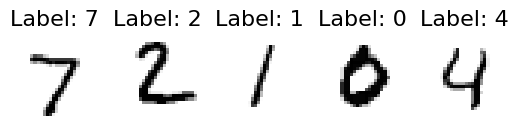

In [6]:
# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=True)
# X_train, y_train, X_test, y_test = load_MNIST_8(flatten_images=True)

# Display some images
plot_some_imgs(X_test, y_test)

In [ ]:
def single_run(X_train, X_test, y_train, y_test, 
               lr, lam, hidden_layer_num, node_per_hidden, 
               hidden_activation, output_activation=softmax,
               epochs=300, batch_size=32, plot_or_not=False,
               loss_func_and_name=(cross_entropy_loss_method, "CE"), #(MSELoss_method, "MSE")
               test_func_and_name=(cross_entropy_loss_method, "CE"), 
               result_filepath=None, store_params=False, intermediate_epochs=None):    
    """
    Performs a training with the given parameters

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    layer_list = [X_train.shape[1]] + [node_per_hidden]*hidden_layer_num + [y_train.shape[1]]
    beta0 = _beta_init(layer_list)
    model = jit(get_neural_network_model(hidden_layer_num,activation=hidden_activation,
                                         output_activation=output_activation))

    # Create gradient from loss function. Also get the accuracy function
    loss_func = jit(loss_func_and_name[0](model=model, lam=lam))   
    loss_grad = jit(grad(loss_func))
    accuracy_func = jit(accuracy_func_method(model))

    # (usually MSE) loss function for evaluation
    if plot_or_not:
        test_func = jit(test_func_and_name[0](model))
    else:
        test_func = None

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, 
                      grad_method=loss_grad,beta0=beta0, 
                      n_epochs=epochs, batch_size=batch_size,
                      test_loss_func= test_func, lr=lr, 
                      intermediate_epochs=intermediate_epochs)

    # Plot if wanted ...
    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], ylabel=test_func_and_name[1])

    # Add accuracy scores
    result["test_accuracy"]  = float(accuracy_func(result["beta_final"], X_test, y_test))
    result["train_accuracy"] = float(accuracy_func(result["beta_final"], X_train, y_train))
    # Also store the model for potential later use
    result["model"] = model

    # Store the result to given file
    if result_filepath:

        _dict_to_store =  { "lr"                : lr, 
                            "lam"               : lam,
                            "batch_size"        : batch_size,
                            "hidden_layer_num"  : hidden_layer_num, 
                            "node_per_hidden"   : node_per_hidden, 
                            "hidden_activation" : hidden_activation.__name__,
                            "output_activation" : output_activation.__name__,
                            "loss_function"     : loss_func_and_name[1],
                            "train_num"         : y_train.shape[0],
                            "test_num"          : y_test.shape[0]
                          }
        if store_params:
            _dict_to_store["beta_final"] = {key: value.tolist() for key, value in result["beta_final"].items()}

        # Possibility of storing run with fewer epochs
        if intermediate_epochs is not None:
            for ie, be in zip(intermediate_epochs, result["beta_intermediate"]):
                _dict_to_store = {"test_accuracy"     : float(accuracy_func(be, X_test, y_test)), 
                                  "train_accuracy"    : float(accuracy_func(be, X_train, y_train)),
                                  "epochs"            : ie} | _dict_to_store

                append_run_to_file(result_filepath, _dict_to_store)

        _dict_to_store = {"test_accuracy"     : result["test_accuracy"], 
                          "train_accuracy"    : result["train_accuracy"],
                          "epochs"            : epochs} | _dict_to_store
        append_run_to_file(result_filepath, _dict_to_store)

    return result

In [19]:
## A demonstration
epochs = 50
batch_size = 128 #4096 2048 # 128 # 1024
lr = 0.01 # 0.01
lam = 0
layers = 8
nodes = 1024
test_func_and_name = (accuracy_func_method, "Accuracy")
test_func_and_name = (cross_entropy_loss_method, "CE")
hidden_activation = nn.sigmoid
plot_or_not=False

result = single_run(X_train, X_test, y_train, y_test, 
                    lr=lr, lam=lam, hidden_layer_num=layers, node_per_hidden=nodes, hidden_activation=hidden_activation,
                    epochs=epochs, batch_size=batch_size, 
                    plot_or_not=plot_or_not, test_func_and_name=test_func_and_name,
                    result_filepath="test.json")

print("Accuracy test: ", result["test_accuracy"])
print("Accuracy train: ", result["train_accuracy"])

print(f"{test_func_and_name[1]} test: ", result["test_loss_list"][-1])
print(f"{test_func_and_name[1]} train: ", result["train_loss_list"][-1])

assert(False)

None


  2%|▏         | 1/50 [01:00<49:25, 60.52s/it]


KeyboardInterrupt: 

In [23]:
epochs     = 10
lr         = 0.01
batch_size = 128
lam = 0
filepath = "Results/neural_28_sigmoidTEST.json"
hidden_activation=nn.sigmoid

hidden_layer_nums = [1]
hidden_node_nums = [512] # 784 = size of input layer 

for layers in hidden_layer_nums:
    for nodes in hidden_node_nums:

        result = single_run(X_train, X_test, y_train, y_test, 
                        lr=lr, lam=lam, hidden_layer_num=layers, node_per_hidden=nodes, hidden_activation=hidden_activation,
                        epochs=epochs, batch_size=batch_size, 
                        plot_or_not=False, result_filepath=filepath)
        print(f"layers: {layers}, nodes: {nodes}, training_acc: {result['train_accuracy']}, test_acc: {result['test_accuracy']}")

None


 20%|██        | 2/10 [00:17<01:08,  8.60s/it]


KeyboardInterrupt: 

### Architecture

In [24]:
epochs     = 10
lr         = 0.01
batch_size = 128
lam = 0
filepath = "Results/neural_28_sigmoidTEST.json"
hidden_activation=nn.sigmoid

hidden_layer_nums = [0, 1, 2, 3, 4, 5, 6, 7, 8]
hidden_node_nums = [8, 16, 32, 64, 128, 256, 512, 1024] # 784 = size of input layer 
hidden_node_nums.reverse()

for layers in hidden_layer_nums:
    for nodes in hidden_node_nums:

        result = single_run(X_train, X_test, y_train, y_test, 
                        lr=lr, lam=lam, hidden_layer_num=layers, node_per_hidden=nodes, hidden_activation=hidden_activation,
                        epochs=epochs, batch_size=batch_size, 
                        plot_or_not=False, result_filepath=filepath)
        print(f"layers: {layers}, nodes: {nodes}, training_acc: {result['train_accuracy']}, test_acc: {result['test_accuracy']}")

None


 40%|████      | 4/10 [00:34<00:51,  8.58s/it]


KeyboardInterrupt: 

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\Code\plot.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


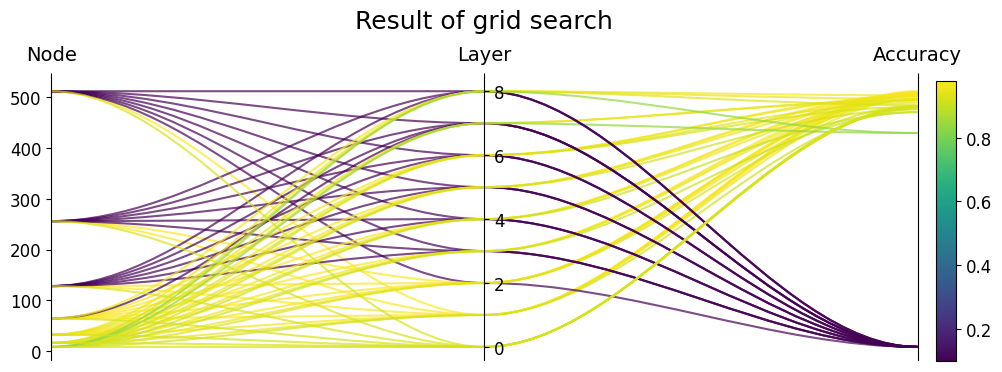

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\Code\plot.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


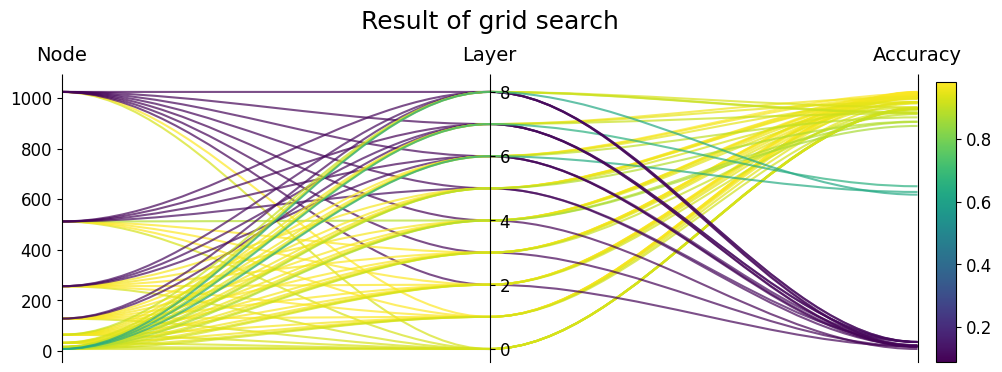

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\Code\plot.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


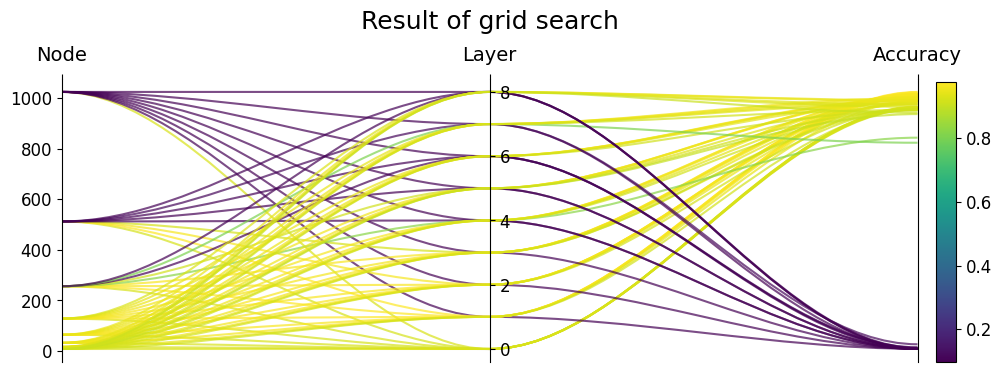

In [27]:
def plot_NN_grid_from_file(filepath):

    run_list = load_run_from_file(filepath)


    data = {
        "Node": [],
        "Layer": [],
        "Accuracy": [],
    }

    for run in run_list:
        
            data["Node"].append(run["node_per_hidden"])
            data["Layer"].append(run["hidden_layer_num"])
            data["Accuracy"].append(run["test_accuracy"])

    plot_grid_search_result(data)

plot_NN_grid_from_file("Results/neural_28_relu.json")
plot_NN_grid_from_file("Results/neural_28_sigmoid.json")
plot_NN_grid_from_file("Results/neural_28_tanh.json")

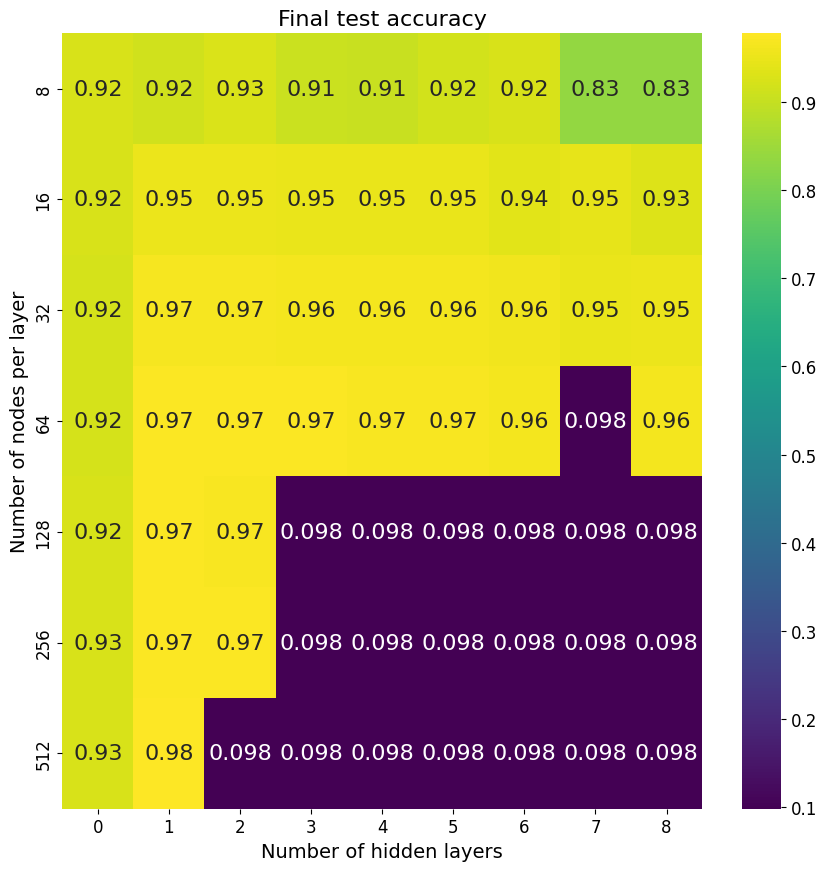

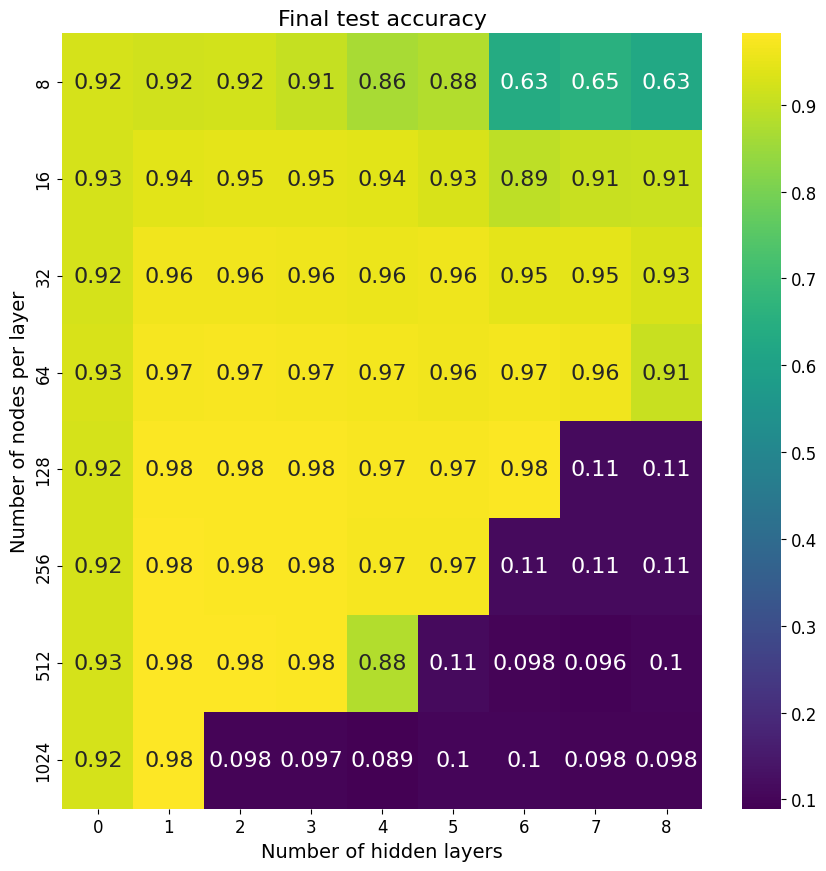

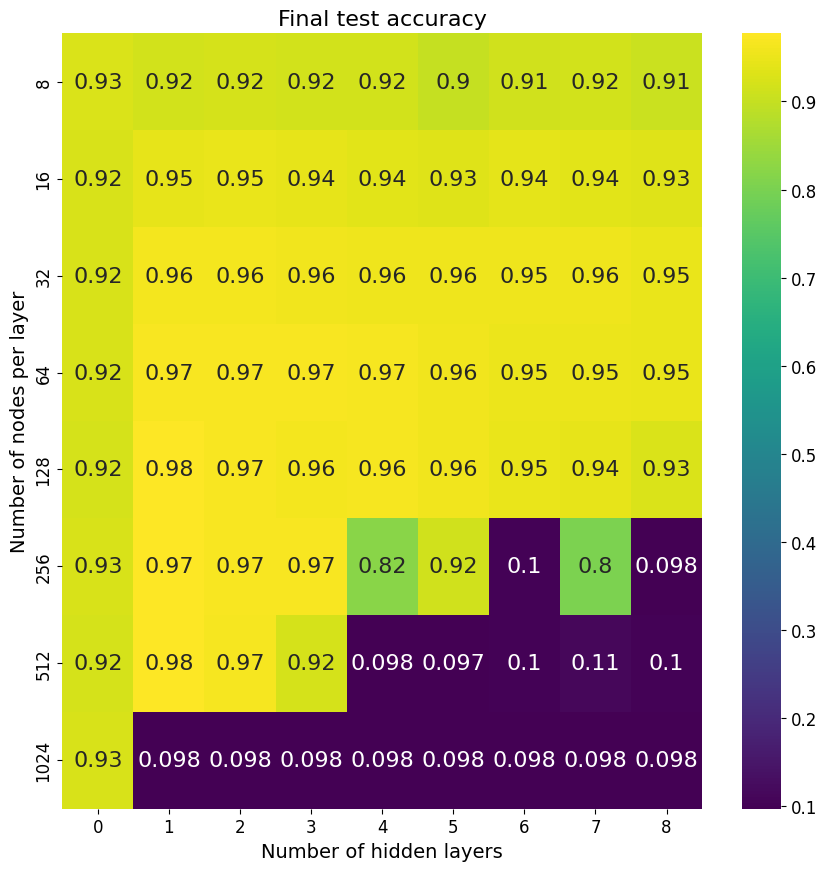

In [35]:
def plot_hidden_node_hidden_layer_grid(filepath):


    # Initialize lists for nodes, layers, and accuracies
    nodes_list = []
    layers_list = []
    accuracy_list = []

    # Load data
    data_list = load_run_from_file(filepath)

    # Iterate through the data_list
    for i, data in enumerate(data_list):
        # Extract relevant information
        nodes = data["node_per_hidden"]
        layers = data["hidden_layer_num"]
        accuracy = data["test_accuracy"]

        # Append to the lists
        nodes_list.append(nodes)
        layers_list.append(layers)
        accuracy_list.append(accuracy)

    # Get unique nodes and layers along with their original indices
    unique_nodes, node_indices = np.unique(nodes_list, return_inverse=True)
    unique_layers, layer_indices = np.unique(layers_list, return_inverse=True)

    # Create a matrix and fill with accuracies
    accuracy_matrix = np.empty((len(unique_nodes), len(unique_layers)))
    accuracy_matrix.fill(np.nan)

    for i, (node, layer, acc) in enumerate(zip(node_indices, layer_indices, accuracy_list)):
        accuracy_matrix[node, layer] = acc

    # Make the plot
    fig, ax = plt.subplots(figsize=(9, 9))
    sns.heatmap(accuracy_matrix, annot=True, ax=ax, cmap="viridis", cbar=True)

    # Title
    ax.set_title("Final test accuracy")

    # Handle labels
    ax.set_xlabel("Number of hidden layers")
    ax.set_ylabel("Number of nodes per layer")

    ax.set_xticks(np.arange(len(unique_layers)) + 0.5)
    ax.set_yticks(np.arange(len(unique_nodes)) + 0.5)
    ax.set_xticklabels(unique_layers)
    ax.set_yticklabels(unique_nodes)

    plt.tight_layout()
    plt.show()

plot_hidden_node_hidden_layer_grid("Results/neural_28_relu.json")
plot_hidden_node_hidden_layer_grid("Results/neural_28_sigmoid.json")
plot_hidden_node_hidden_layer_grid("Results/neural_28_tanh.json")

### Final model evaluation

We make confusion matrix ...

100%|██████████| 40/40 [35:20<00:00, 53.00s/it]


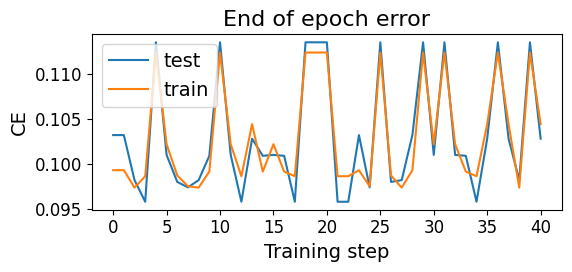

test:  0.10280001908540726
train:  0.10441665351390839
CE test:  0.10280002
CE train:  0.10441665


In [28]:
## A demonstration
epochs = 40
batch_size = 32#64#128 #4096 2048 # 128 # 1024
lr = 0.001 # 0.01
lam = 0.00001

layers = 8
nodes  = 512

result = single_run(X_train, X_test, y_train, y_test, 
                    lr=lr, lam=lam, hidden_layer_num=layers, node_per_hidden=nodes, hidden_activation=nn.sigmoid,
                    epochs=epochs, batch_size=batch_size, 
                    plot_or_not=True, test_func_and_name=(accuracy_func_method, "Accuracy"),
                    result_filepath="test.json")

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

print("CE test: ", result["test_loss_list"][-1])
print("CE train: ", result["train_loss_list"][-1])

model = result["model"]
beta = result["beta_final"]


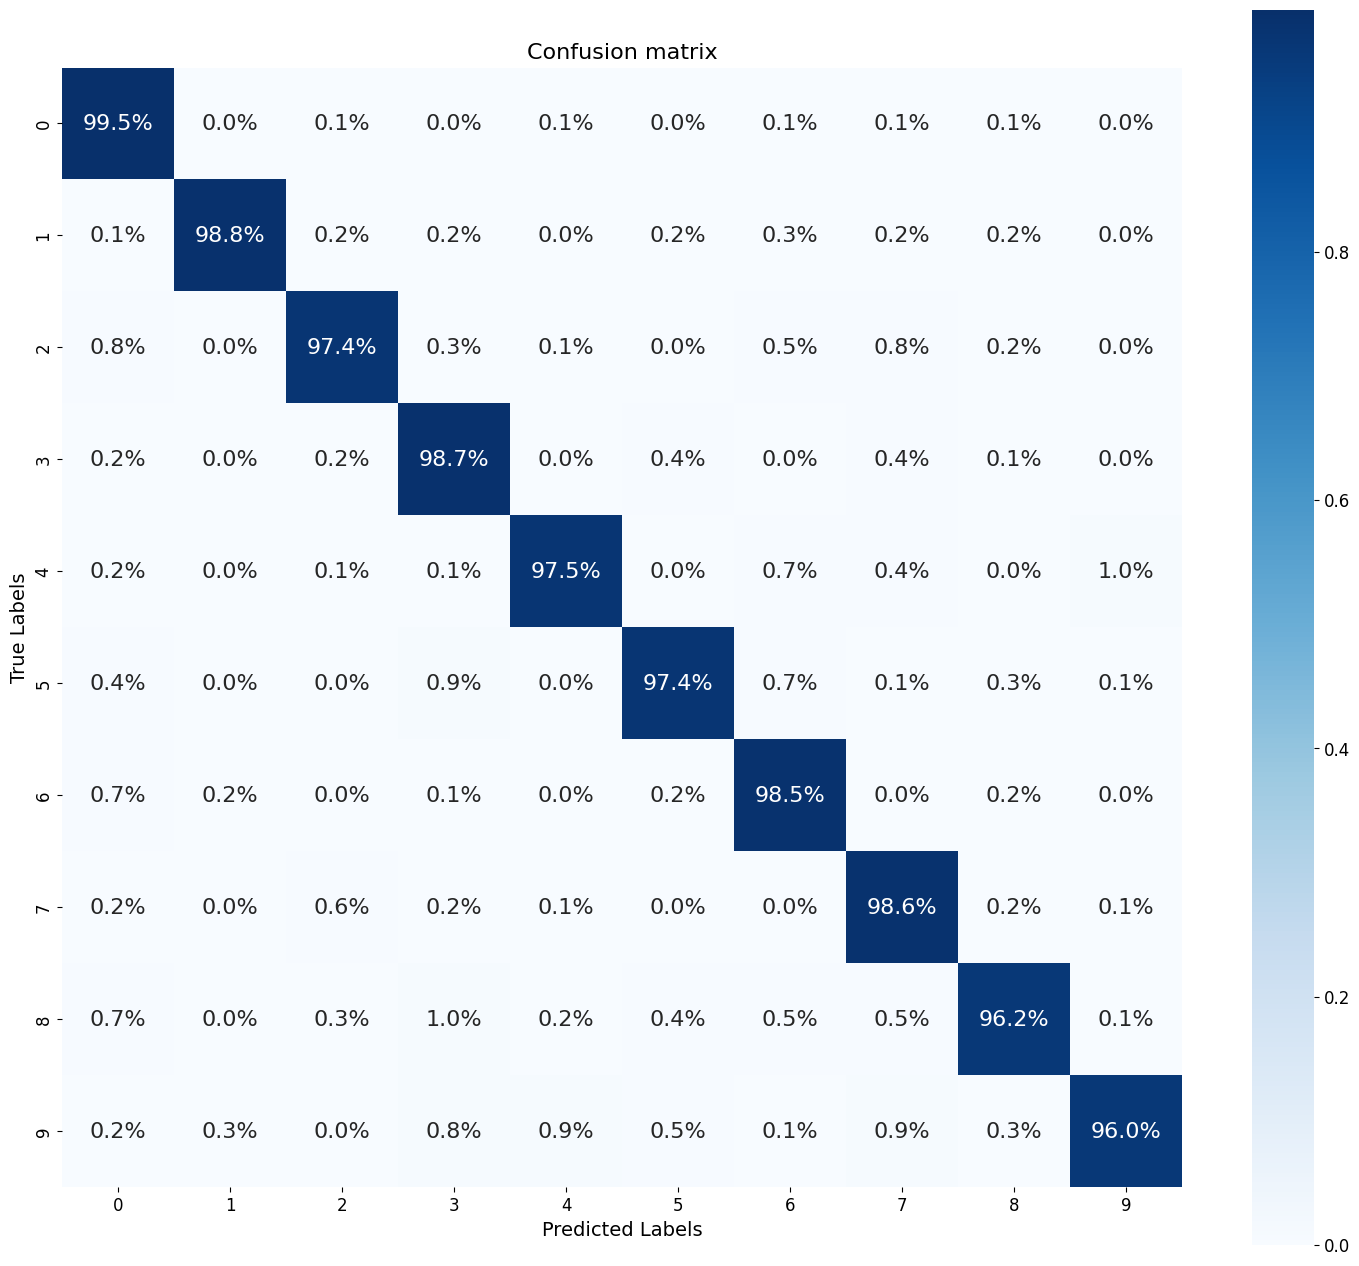

In [7]:
plot_confusion_matrix(X_test, y_test, model, beta, convert_to_percent=True)

Also want to see exactly where the model fails ...

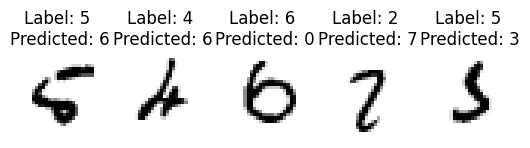

In [8]:
plot_faulty_predictions(X_test, y_test, model, beta)